# Real-time Pose Detection and Classification

This notebook demonstrates how to use MediaPipe Pose Landmarker to detect and classify yoga poses in real-time using a webcam.

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [2]:
def calculate_angle(a, b, c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

In [3]:
def classify_warrior2(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle):
    """Classifies Warrior 2 pose."""
    warrior_2_left_bent = (left_arm_angle > 160 and left_arm_angle < 200 and
                         right_arm_angle > 160 and right_arm_angle < 200 and
                         left_leg_angle > 80 and left_leg_angle < 110 and
                         right_leg_angle > 160 and right_leg_angle < 200)

    warrior_2_right_bent = (left_arm_angle > 160 and left_arm_angle < 200 and
                          right_arm_angle > 160 and right_arm_angle < 200 and
                          right_leg_angle > 80 and right_leg_angle < 110 and
                          left_leg_angle > 160 and left_leg_angle < 200)

    if warrior_2_left_bent or warrior_2_right_bent:
        return True
    return False

In [4]:
def classify_warrior1(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
    """Classifies Warrior 1 pose."""
    # Arms are straight and raised.
    arms_straight = left_arm_angle > 150 and right_arm_angle > 150
    arms_up = left_shoulder_angle > 140 and right_shoulder_angle > 140

    # One leg bent, one leg straight
    warrior_1_left_bent = (arms_straight and arms_up and
                           left_leg_angle > 80 and left_leg_angle < 120 and
                           right_leg_angle > 160)

    warrior_1_right_bent = (arms_straight and arms_up and
                            right_leg_angle > 80 and right_leg_angle < 120 and
                            left_leg_angle > 160)

    if warrior_1_left_bent or warrior_1_right_bent:
        return True
    return False

In [5]:
def classify_tree_pose(left_leg_angle, right_leg_angle, left_ankle, right_ankle, left_knee, right_knee):
    """Classifies Tree pose (Vrksasana)."""
    # Left leg is standing leg
    tree_pose_left_standing = (left_leg_angle > 160 and left_leg_angle < 200 and
                               right_leg_angle < 100 and
                               right_ankle[1] < left_knee[1])

    # Right leg is standing leg
    tree_pose_right_standing = (right_leg_angle > 160 and right_leg_angle < 200 and
                                left_leg_angle < 100 and
                                left_ankle[1] < right_knee[1])

    if tree_pose_left_standing or tree_pose_right_standing:
        return True
    return False

In [6]:
def classify_triangle_pose(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_body_angle, right_body_angle, left_shoulder_angle, right_shoulder_angle):
    """Classifies Triangle pose (Trikonasana)."""
    # Legs should be straight
    legs_straight = left_leg_angle > 160 and right_leg_angle > 160
    
    # Arms should be straight
    arms_straight = left_arm_angle > 150 and right_arm_angle > 150
    
    # Arms raised (approx 90 degrees relative to body, or effectively out)
    # Using shoulder angle (hip-shoulder-wrist)
    arms_out = left_shoulder_angle > 60 and right_shoulder_angle > 60
    
    # Torso bent to one side. 
    # Normal standing is ~180. Triangle involves bending at hip.
    # We check if one side angle is significantly less than 165 indicating a bend.
    torso_bent = left_body_angle < 165 or right_body_angle < 165

    if legs_straight and arms_straight and arms_out and torso_bent:
        return True
    return False

In [7]:
def classify_mountain_pose(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
    """Classifies Mountain pose (Tadasana)."""
    # Legs straight
    legs_straight = left_leg_angle > 170 and right_leg_angle > 170
    
    # Arms straight
    arms_straight = left_arm_angle > 160 and right_arm_angle > 160
    
    # Arms down at sides (angle between hip-shoulder-wrist should be small)
    arms_down = left_shoulder_angle < 30 and right_shoulder_angle < 30

    if legs_straight and arms_straight and arms_down:
        return True
    return False

In [8]:
def classify_plank_pose(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, shoulder_l, ankle_l, shoulder_r, ankle_r):
    """Classifies Plank pose (Phalakasana)."""
    # Legs straight
    legs_straight = left_leg_angle > 160 and right_leg_angle > 160
    
    # Arms straight involved in support
    arms_straight = left_arm_angle > 160 and right_arm_angle > 160
    
    # Body roughly horizontal? 
    # Check if vertical distance between shoulder and ankle is small relative to horizontal
    # This assumes side view.
    # If front view, this logic might fail, but plank is usually side view.
    
    horizontal_l = abs(shoulder_l[1] - ankle_l[1]) < abs(shoulder_l[0] - ankle_l[0])
    horizontal_r = abs(shoulder_r[1] - ankle_r[1]) < abs(shoulder_r[0] - ankle_r[0])
    
    if legs_straight and arms_straight and (horizontal_l or horizontal_r):
        return True
    return False

In [9]:
# Create a PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

I0000 00:00:1767763050.731048 8830806 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1767763050.864619 9095113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1767763050.892081 9095116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [10]:
def process_and_annotate(image, landmark_list):
    annotated_image = image.copy()
    landmarks = landmark_list
    # Get coordinates
    shoulder_l = [landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER.value].y]
    elbow_l = [landmarks[mp.solutions.pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp.solutions.pose.PoseLandmark.LEFT_ELBOW.value].y]
    wrist_l = [landmarks[mp.solutions.pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp.solutions.pose.PoseLandmark.LEFT_WRIST.value].y]

    shoulder_r = [landmarks[mp.solutions.pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp.solutions.pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    elbow_r = [landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ELBOW.value].y]
    wrist_r = [landmarks[mp.solutions.pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp.solutions.pose.PoseLandmark.RIGHT_WRIST.value].y]

    hip_l = [landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP.value].y]
    knee_l = [landmarks[mp.solutions.pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp.solutions.pose.PoseLandmark.LEFT_KNEE.value].y]
    ankle_l = [landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE.value].y]

    hip_r = [landmarks[mp.solutions.pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp.solutions.pose.PoseLandmark.RIGHT_HIP.value].y]
    knee_r = [landmarks[mp.solutions.pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp.solutions.pose.PoseLandmark.RIGHT_KNEE.value].y]
    ankle_r = [landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE.value].y]

    # Calculate angles
    left_arm_angle = calculate_angle(shoulder_l, elbow_l, wrist_l)
    right_arm_angle = calculate_angle(shoulder_r, elbow_r, wrist_r)
    left_leg_angle = calculate_angle(hip_l, knee_l, ankle_l)
    right_leg_angle = calculate_angle(hip_r, knee_r, ankle_r)
    left_shoulder_angle = calculate_angle(hip_l, shoulder_l, wrist_l)
    right_shoulder_angle = calculate_angle(hip_r, shoulder_r, wrist_r)
    left_body_angle = calculate_angle(shoulder_l, hip_l, knee_l)
    right_body_angle = calculate_angle(shoulder_r, hip_r, knee_r)

    pose = "Unknown"
    if classify_warrior2(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle):
        pose = "Warrior 2"
    elif classify_warrior1(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
        pose = "Warrior 1"
    elif classify_tree_pose(left_leg_angle, right_leg_angle, ankle_l, ankle_r, knee_l, knee_r):
        pose = "Tree Pose"
    elif classify_triangle_pose(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_body_angle, right_body_angle, left_shoulder_angle, right_shoulder_angle):
        pose = "Triangle Pose"
    elif classify_mountain_pose(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
        pose = "Mountain Pose"
    elif classify_plank_pose(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, shoulder_l, ankle_l, shoulder_r, ankle_r):
        pose = "Plank Pose"

    # Display the pose
    # Display the pose with outline for better visibility
    # Outline (black)
    cv2.putText(annotated_image, pose, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 10, cv2.LINE_AA)
    # Text (white for high contrast)
    cv2.putText(annotated_image, pose, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 3, cv2.LINE_AA)
    
    # Draw landmarks
    for idx, landmark in enumerate(landmark_list):
        x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
        cv2.circle(annotated_image, (x, y), 5, (0, 255, 0), -1)

    # Draw connections
    connections = mp.solutions.pose.POSE_CONNECTIONS
    for connection in connections:
        start_idx = connection[0]
        end_idx = connection[1]
        start_point = (int(landmark_list[start_idx].x * image.shape[1]),
                       int(landmark_list[start_idx].y * image.shape[0]))
        end_point = (int(landmark_list[end_idx].x * image.shape[1]),
                     int(landmark_list[end_idx].y * image.shape[0]))
        cv2.line(annotated_image, start_point, end_point, (255, 0, 0), 2)
    
    return annotated_image

In [11]:
# Initialize the video capture from the default camera.
# cap = cv2.VideoCapture(1)
# 
# try:
#     while cap.isOpened():
#         # Read a frame from the video.
#         success, image = cap.read()
#         if not success:
#             print("Ignoring empty camera frame.")
#             # If loading a video, use 'break' instead of 'continue'.
#             continue
# 
#         # Convert the BGR image to RGB.
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# 
#         # Process the image and get the pose landmarks.
#         mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
#         detection_result = detector.detect(mp_image)
# 
#         annotated_image = image.copy()
#         if detection_result.pose_landmarks:
#             for landmark_list in detection_result.pose_landmarks:
#                  annotated_image = process_and_annotate(image, landmark_list)
# 
#         # Convert the RGB image back to BGR for display.
#         annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
# 
#         # Display the annotated image.
#         cv2.imshow('MediaPipe Pose Landmark', annotated_image)
# 
#         # Break the loop if 'q' is pressed.
#         if cv2.waitKey(5) & 0xFF == ord('q'):
#             break
# except KeyboardInterrupt:
#     print("Program interrupted by user.")
# finally:
#     # Release the video capture and destroy all windows.
#     cap.release()
#     cv2.destroyAllWindows()

## Static Image Detection

Input an image path to run pose detection on a single image.

W0000 00:00:1767763056.311173 9095110 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


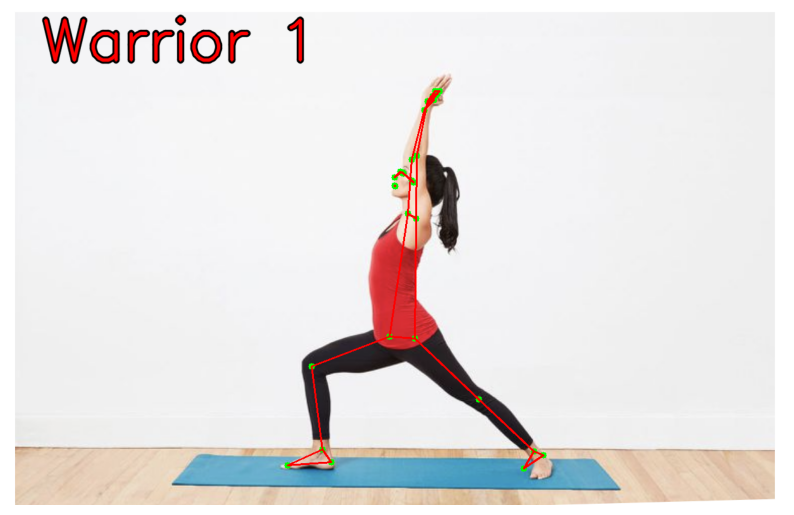

In [12]:
import matplotlib.pyplot as plt

IMAGE_PATH = 'images/warrior_1.png'
image = cv2.imread(IMAGE_PATH)

if image is None:
    print(f"Error: Could not read image from {IMAGE_PATH}. Please check the path.")
else:
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    detection_result = detector.detect(mp_image)

    # Draw the pose annotation on the image.
    annotated_image = image.copy()
    if detection_result.pose_landmarks:
        for landmark_list in detection_result.pose_landmarks:
            annotated_image = process_and_annotate(image, landmark_list)

    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.show()

I0000 00:00:1767763057.751215 8830806 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1767763057.756224 9095273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


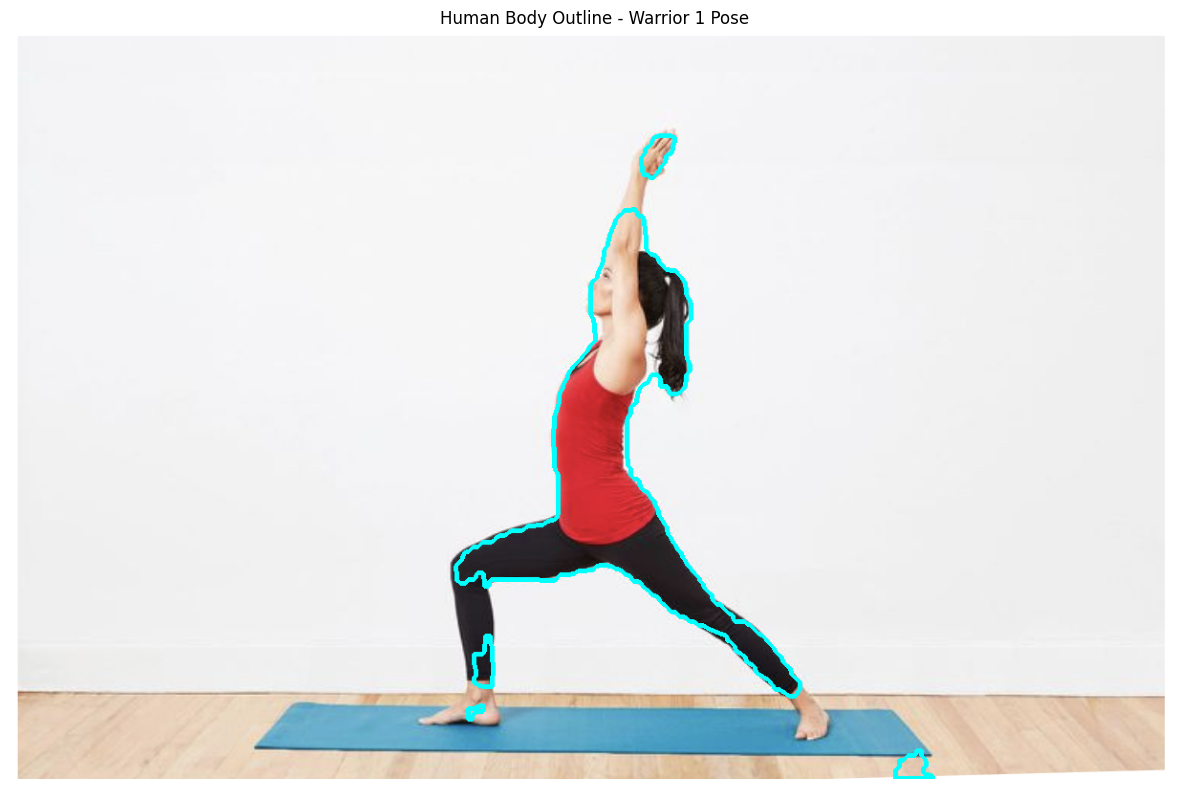

In [ ]:
mp_selfie_segmentation = mp.solutions.

# Load the image
image_path = "images/warrior_1.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform segmentation to get the body mask
with mp_selfie_segmentation.SelfieSegmentation(model_selection=1) as selfie_segmentation:
    results = selfie_segmentation.process(image_rgb)
    
    # Get the segmentation mask (values between 0 and 1)
    mask = results.segmentation_mask
    
    # Create a binary mask (threshold at 0.5)
    binary_mask = (mask > 0.5).astype(np.uint8) * 255
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    # Find contours (outline) of the body
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a copy of the original image to draw the outline
    output_image = image_rgb.copy()
    
    # Draw the outline with a bright color (cyan/turquoise)
    outline_color = (0, 255, 255)  # Cyan in RGB
    cv2.drawContours(output_image, contours, -1, outline_color, thickness=3)

# Plot the result
plt.figure(figsize=(12, 8))
plt.imshow(output_image)
plt.title("Human Body Outline - Warrior 1 Pose")
plt.axis('off')
plt.tight_layout()
plt.show()


I0000 00:00:1767763557.978230 8830806 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1767763558.069880 9108497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1767763558.085356 9108497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


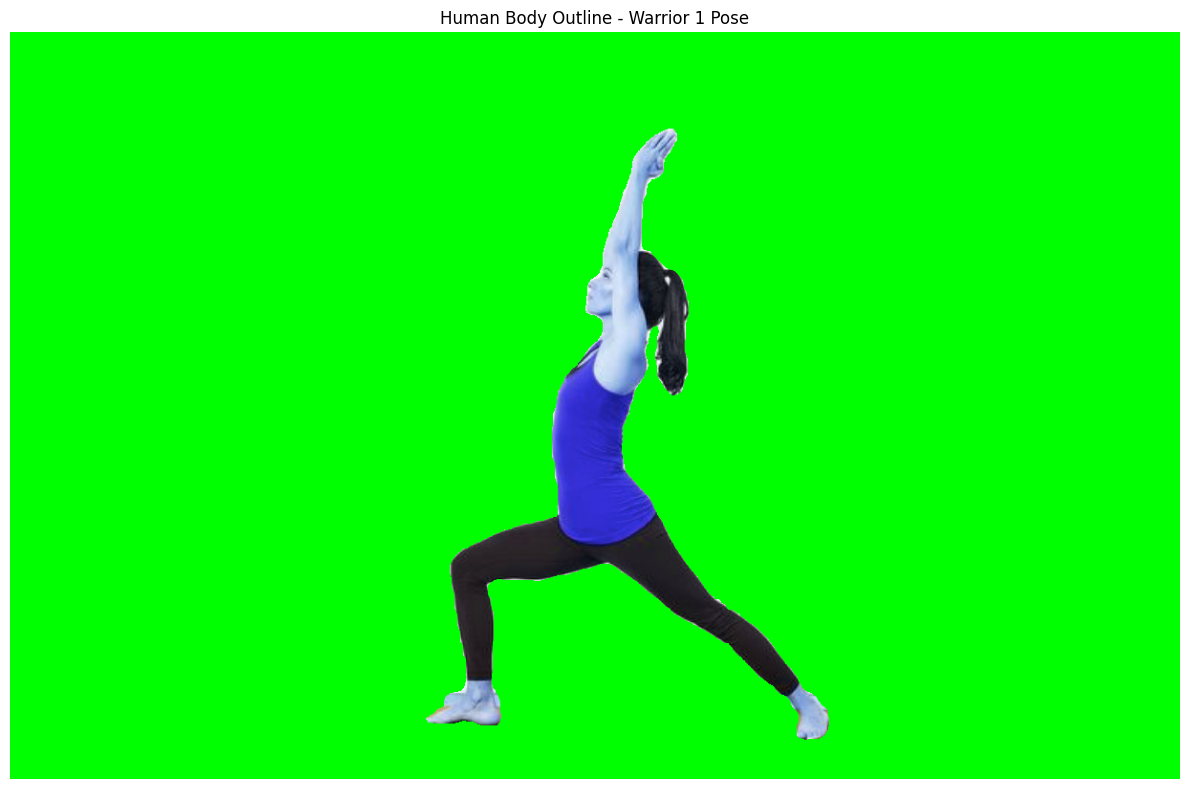

: 

In [ ]:
mp_pose = mp.solutions.pose

# Load the image
image_path = "images/warrior_1.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Initialize MediaPipe Pose with segmentation enabled
with mp_pose.Pose(
    static_image_mode=False, 
    model_complexity=1, 
    enable_segmentation=True, # <--- This is the magic switch
    min_detection_confidence=0.5
) as pose:

    # (Assuming you have a 'frame' from your webcam/video)
    # Convert BGR to RGB
    results = pose.process(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))

    if results.segmentation_mask is not None:
        # The mask is a float array (0.0 to 1.0)
        # 1.0 = definitely human, 0.0 = background
        
        # Create a binary mask where 'True' is the person
        condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.5
        
        # Example: Keep the person, make background Green Screen
        bg_image = np.zeros(image.shape, dtype=np.uint8)
        bg_image[:] = (0, 255, 0) # Green background
        
        # Combine them
        output_image = np.where(condition, image, bg_image)
        
        cv2.imshow('Segmented Output', output_image)
    
plt.figure(figsize=(12, 8))
plt.imshow(output_image)
plt.title("Human Body Outline - Warrior 1 Pose")
plt.axis('off')
plt.tight_layout()
plt.show()